# INSY 695: Assignment 1- End-to-End Machine Learning Project 

Submitted by: Shivangi Soni

ID: 260994072

Customer churn is the percentage of customers that stopped using the company's product or service during a given time. It is one of the most important metrics for businesses because it impedes growth. Considering it is easier to retain customers than to acquire new ones, machine learning models that can predict if a customer will stop using a company's products/services can prove to be very valulable for businesses. After understanding which customer will churn, appropriate measures can be taken to retain the customer. This notebook follows the end-to-end machine learning steps to build a classification model for a Telecom company's Churn dataset. 


The dataset includes information about:

1. Customers who churned/ stopped using the company's services 
2. Services available to customers — phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
3. Customer account information — how long they’ve been a customer, the type of contract (month-to-month, one-year, two-years), payment method, paperless billing, monthly charges, and total charges
4. Demographic information of customers — gender, age, and if they have partners and dependents

To build the classification model, the data was first cleaned and exploratory analysis was performed to understand the relationships between variables. Then feature engineering and selection were performed and supervised machine learning algorithms such as Logistic Regression, Random Forest, Gradient Boosting Tree, and KNN were used to build a classification model. Oversampling technique called SMOTE was also applied to the training dataset before training the models to address the problem of imbalance in the dataset. 

For this particular case, it is defnitely bad to have both false negative and positive. If we have a false negative, customer will be identified as non-churn when he/she is going to leave the company, which will mean that the company will lose him/her since they will not focus on retaining that customer. However, if someone is mis-classified as churn customer but they are non-churn customer, then the company will be spending a lot of resources to make sure that they retain the customer who wasn't planning to leave anyways. Hence, to measure performance of the model, F1 score was chosen as the performnace metric because it seeks a balance between Precision and Recall, which is extremely useful in scenarios involving imbalanced dataset. The best model was obtained from Gradient Boosting Tree since it had the highest F1 score. 


# Step 1: Frame the Problem and look at the the big picture 

As mentioned above, the pain point that was addressed here was to determine which customers will most likely stop using a company's telecom services. The solution can help company identify which customers should they focus on. Human intervention will be needed to address what kind of offers/promotions they can provide the customers. 


In [1]:
#load libraries 

import pandas as pd 
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#install pandas-profiling if needed
#!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

import pandas_profiling as pp
from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

#install pandas-profiling if needed
#!pip install imblearn --user
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# Step 2: Get the data 

The dataset was obtained from the following link: https://www.kaggle.com/blastchar/telco-customer-churn

In [2]:
#load the dataset 
df = pd.read_csv(r"C:\Users\shiva\Downloads\archive (1)\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Step 3: Explore the data 

 Starting the data exploration using the pandas profiling report to get a high level overview of the data 

In [3]:
# Generating a HTML report
profile = df.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="output.html")
profile

Summarize dataset:   0%|          | 0/34 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Insights from the above report: 

1. There are no missing values 
2. 18 out of 21 variables are categroical 
3. Multiple lines is correlated with phone service - The correlation will be explored further in the coming steps.
4. The scale of numerical variables (tenure, Monthly Charges, and Total Charges) varies a lot - so these varaibles will be standardized.


This report gave a good high level overview of the dataset. Now, the dataset will be explored in more depth to derive insights before preparing the dataset for the model.

In [3]:
#checking the type of all the variables 
df.info()

#total charges is saved as an object, but it should be a numeric value 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


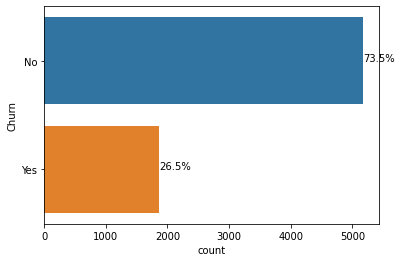

In [4]:
#checking to see if the data is imablanced by looking at the distrbution of the target variable (Churn) 
ax = sns.countplot(y="Churn", data=df)
total = len(df['Churn'])
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() 
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

The data is mildly imbalanced with the minority class (churned customers) being 26.5%. This is reasonable since we want less churned customers. However, the imlabance in data can lead the model to have poor performance on the minority class. Hence, sampling technique called SMOTE will be applied before the model is trained to address this issue. SMOTE will create synthetic examples for the minority class, which will address the imbalance in the dataset.

In [5]:
#getting stats for all the numerical variables 
df[['tenure','MonthlyCharges','TotalCharges']].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


The results above show that all the numerical variables have varying scales, so data will be standardized while preparing the data for the model to avoid the bias that can be created by the different scales.

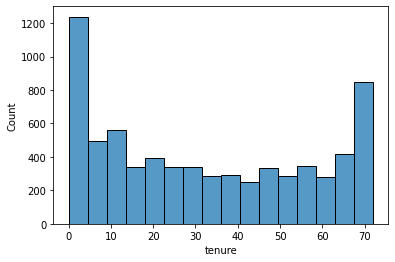

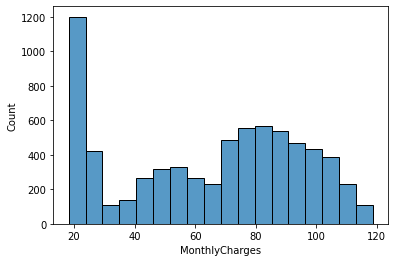

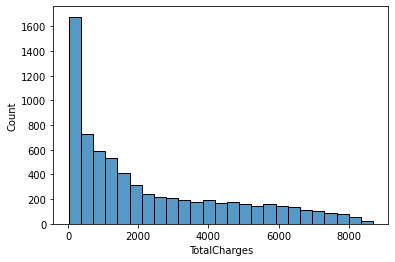

In [6]:
#plotting histogram of all numerical variables to visualize their distribution 
numerical = ['tenure','MonthlyCharges','TotalCharges']
for i in numerical:
    sns.histplot(df[i])
    plt.show()

As it can be seen above, the distibution of the numerical variables do not follow normal distrbution. On an average, people have been with the company for around 32 months and pay around \\$64 monthly and \\$2283 in total. Total charges is skewed towards the right. 

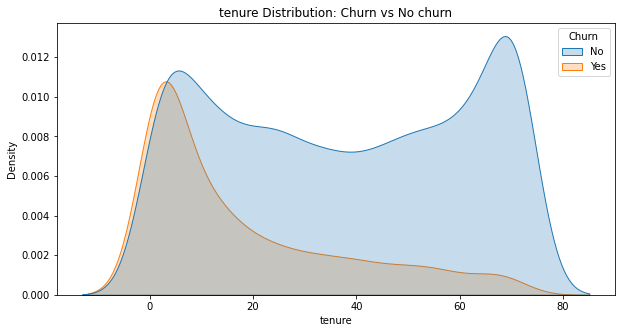

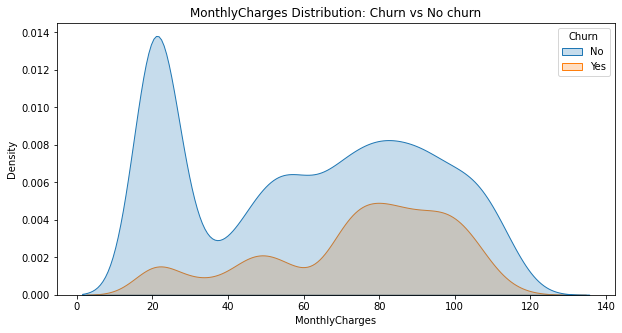

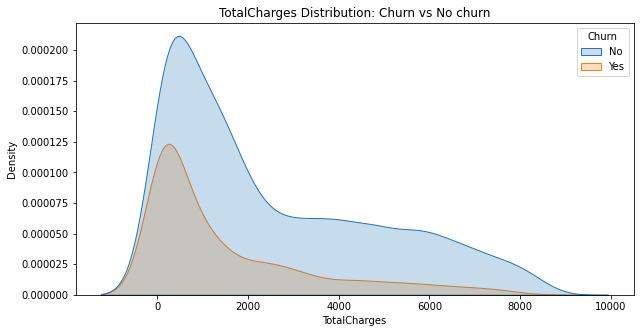

In [7]:
def Num_dist(feature):
    fig = plt.figure(figsize=(10,5))
    ax = sns.kdeplot(data=df, x=feature, hue="Churn", shade = True)
    title_str = feature + " Distribution: Churn vs No churn"
    plt.title(title_str)
    plt.show()
                     
Num_dist('tenure')
Num_dist('MonthlyCharges')
Num_dist('TotalCharges')

From above distribution, churn customers are 
- have tenure of less than a year
- majority of them pay more than \\$65 monthly charges as compared to majority of non-churn customers paying less than \\$40 

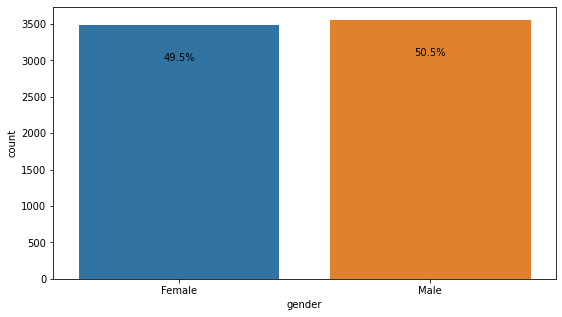

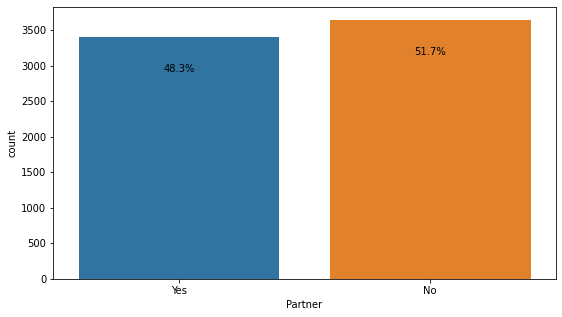

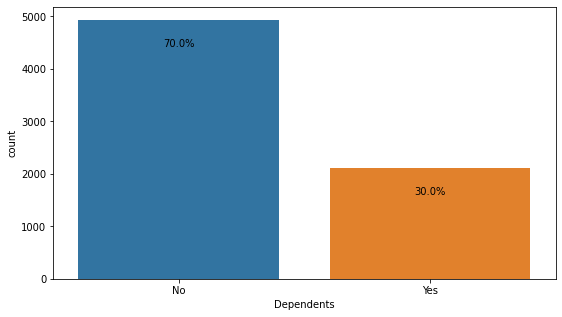

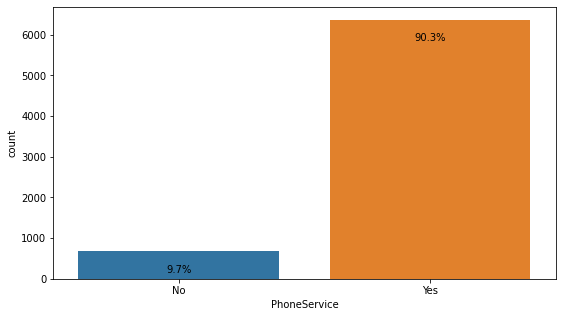

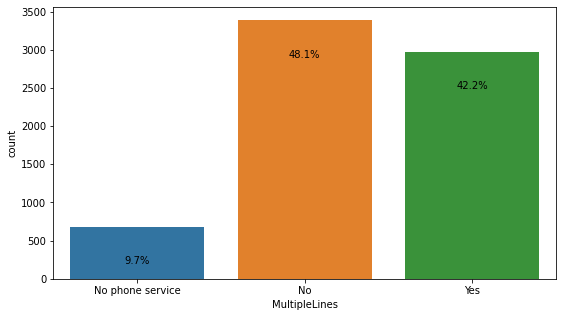

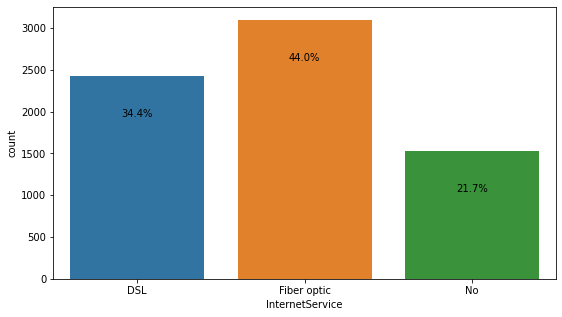

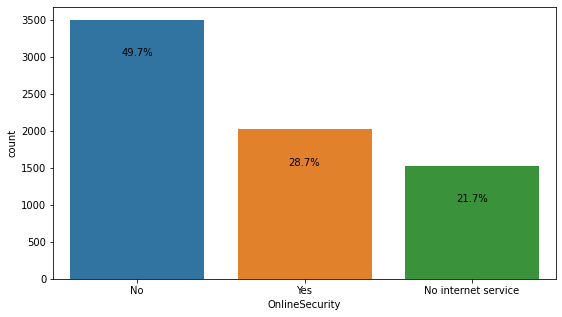

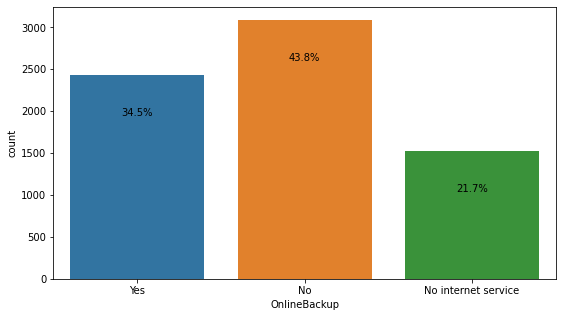

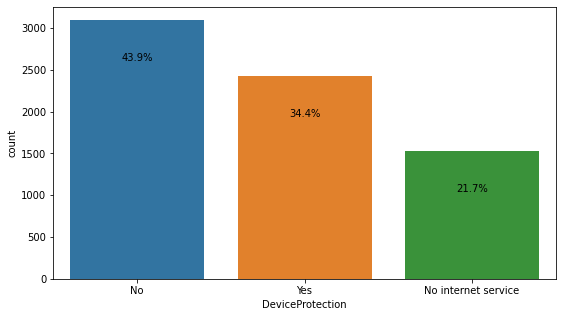

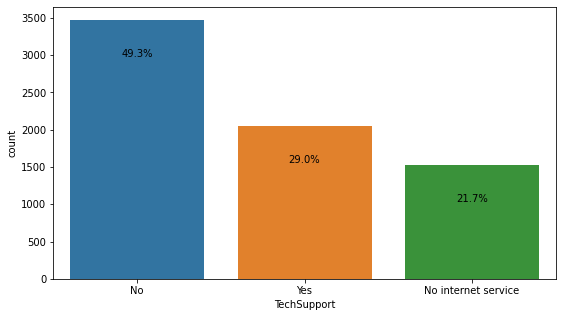

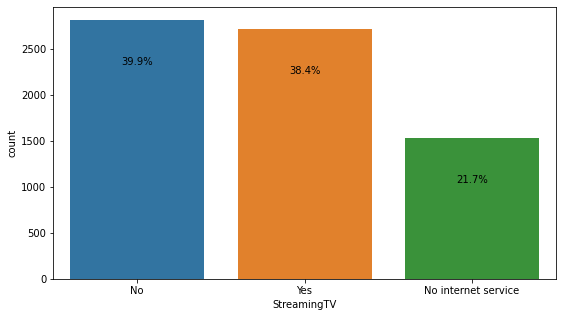

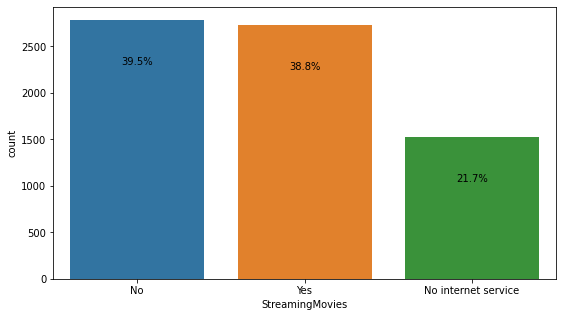

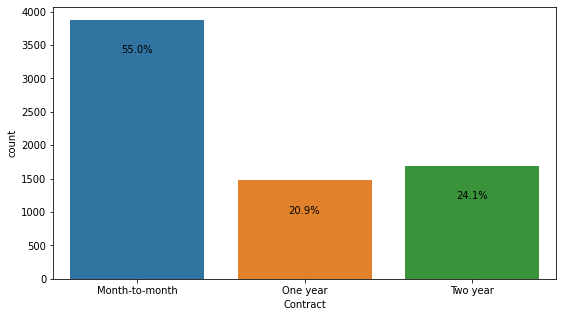

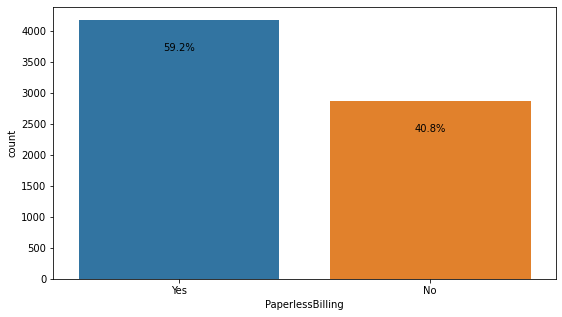

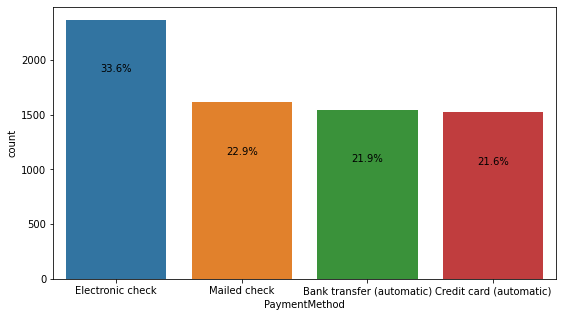

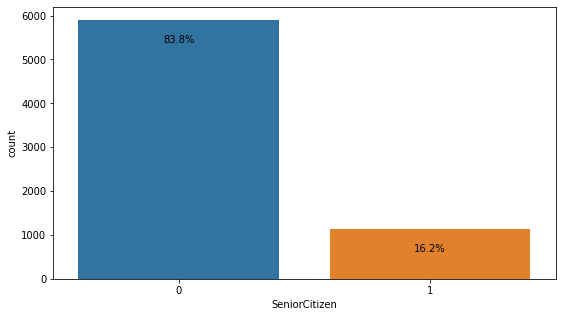

In [8]:
#making list of all categorical variables to understand their distrbutuon

categorical = []
col_list = df.columns.tolist()
for i in col_list:
    if df[i].dtypes == 'object':
        categorical.append(i)
#Customer ID can be removed since it is not a categorical variable and churn can be removed since it has already been plotted 
categorical.remove('customerID')
categorical.remove('Churn')
categorical.append('SeniorCitizen') #Since senior citizen is of type 'int64', it has to be manually appended to the list
total = len(df)

#plotting histograms of all categorical variables 
for i in categorical: 
    plt.figure(figsize=(9,5)) 
    graphs=sns.countplot(x = i, data=df)
    for p in graphs.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + p.get_height()-450
        graphs.annotate(percentage, (x, y),ha = 'center', va = 'center')
    

Some of the interesting insights that can be observed from the above plots:
1. Around 55% of the consumers are on month-to-month contract 
2. The data is quite balanced in terms of gender and if the people have partners or not
3. In terms of services that the consumers use, majority of people have streaming movies and TV

These bar plots help to give a very high level overview of the categorical variables; however, it might be more helpful to see if we can find some patterns if we plot the same plots but divide the cosumers between churn and non-churn. 

In [9]:
def Create_label(ax):
    """ Display data label for given axis """
    for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/ 2
                    , bar.get_height() + 0.01
                    , str(round(100 * bar.get_height(),2)) + '%'
                    , ha = 'center'
                    , fontsize = 13)
            
            
def var_churn_dist(data, cols, distribution_col):
    """ Distribution of categorical variable based on target variable """
    
    for i,feature in enumerate(cols):
        
        feature_summary = data[feature].value_counts(normalize=True).reset_index(name='Percentage')
        
        plt_cat = sns.catplot(x=feature
                , y='Percentage'
                , data = feature_summary
                , col=distribution_col
                , kind='bar'
                , aspect = 0.8
                , alpha = 0.6)
        
        if feature == 'PaymentMethod':
            plt_cat.set_xticklabels(rotation= 65, horizontalalignment = 'right')
        
        
        for ax1, ax2 in plt_cat.axes:
            Create_label(ax1)
            Create_label(ax2)
        
        
        plt.ylim(top=1)
        plt.subplots_adjust(top = 0.9)
        plt.gcf().suptitle(feature+" distribution",fontsize=14)
    plt.show()

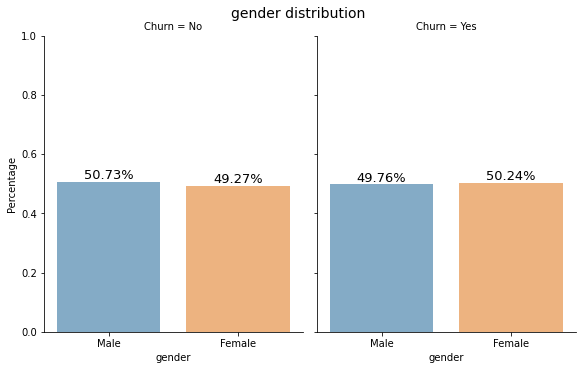

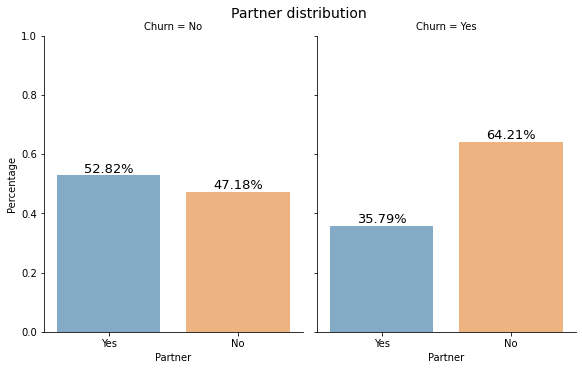

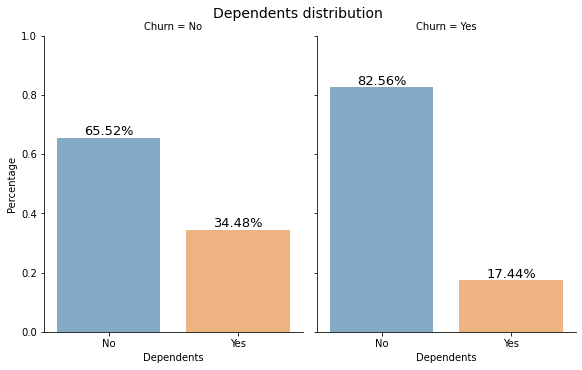

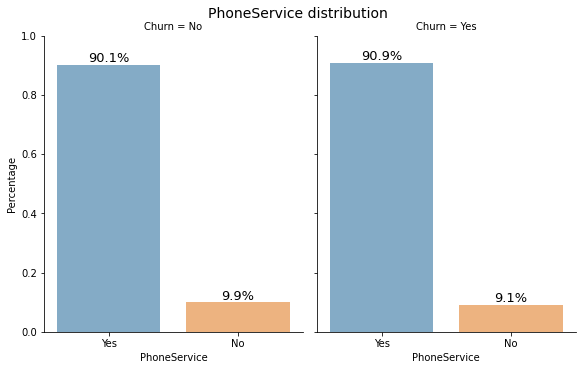

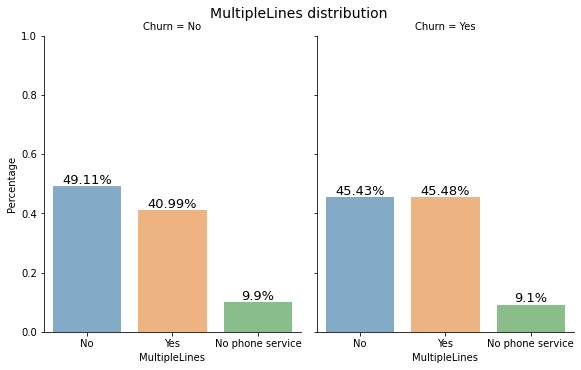

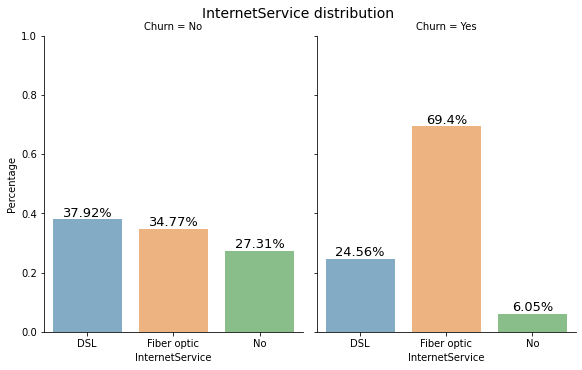

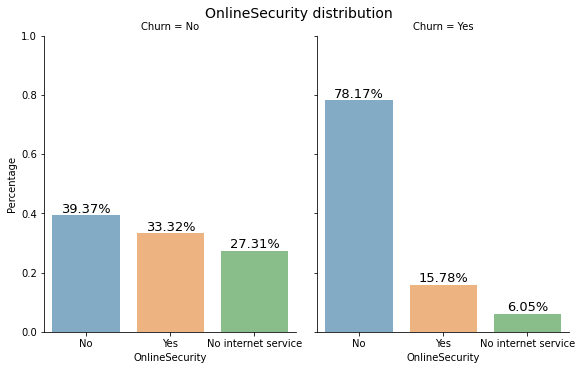

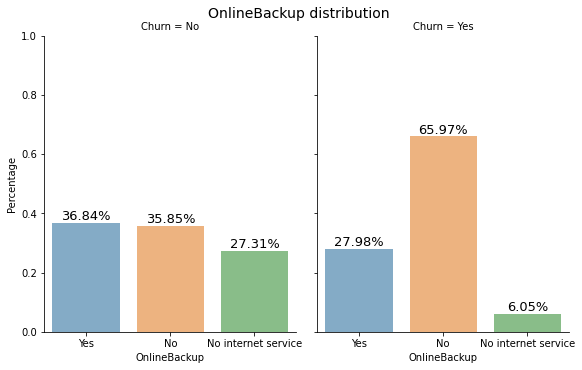

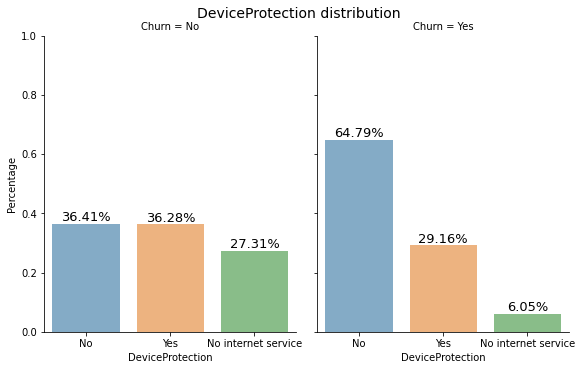

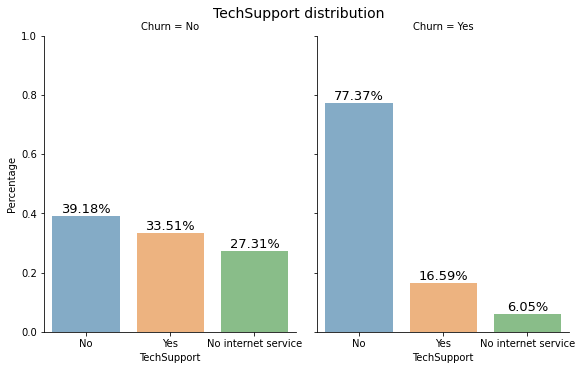

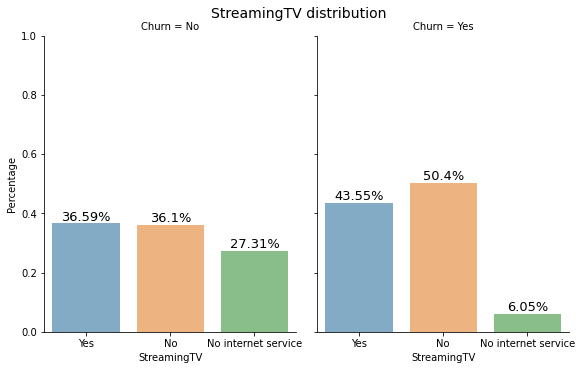

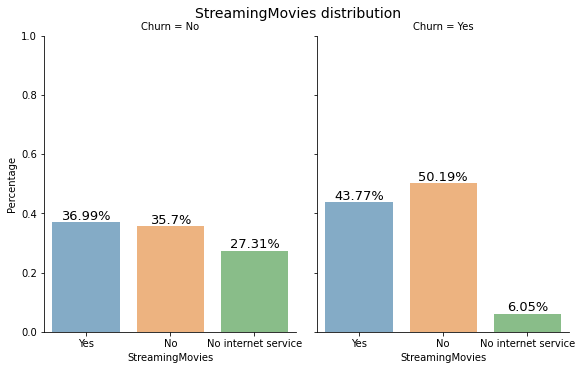

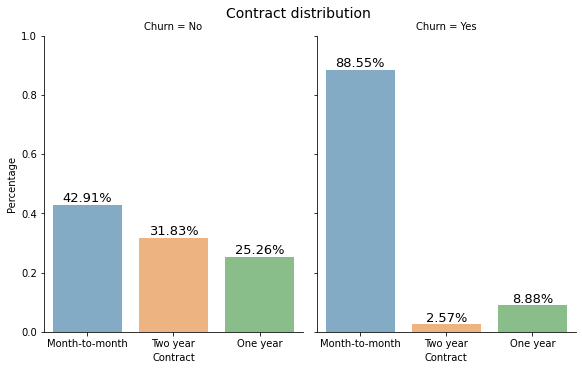

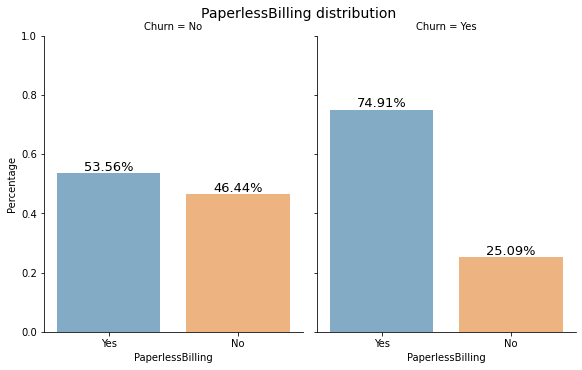

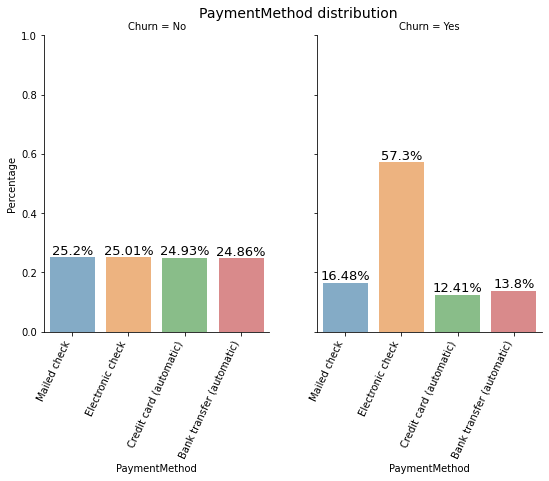

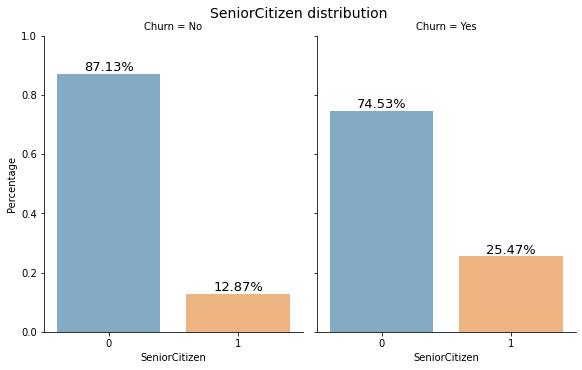

In [10]:
churn_summary = df.groupby('Churn')
var_churn_dist(churn_summary, categorical,'Churn')

Some insights from the plots above:
1. Churn status is not affected by gender.
2. People without partners and dependants opt for leaving the services. It might be useful to aim for these people to market products better.
3. Almost 90% of the churned customers with phone services have churned implying phone services need to be improved.
4. Multiple lines is almost equally distributed amongst those who opted for it and those who didn't implying multiple services might not be an imprtant factor.
5. People who opted for Fiber optic have churned the most indicating that the service needs to be improved.
6. Customers who do not have services like Online Security, Online Backup and Tech Support are the ones leaving the platform 
7. Seniors citizens are more likely to churn.
8. People on a month-to-month contract are more likley to churn. This might just be because people can't end yearly contracts without penalty.
9. More than 50% of the people who opted for paperless billing churned.
10. People who payment is via Electronic check are more likely to churn.

# Step 4: Prepare the Data

In [11]:
#Getting the sum of null values
null = df.isna().sum()
print(null)
#Total of 11 missing values (all in tota charges) so it is reasonable to get rid of them 
df = df.dropna()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


In [12]:
#creating dummy variables for all categorical variables 
df = pd.get_dummies(df, columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn'], drop_first=True)

#Renaming Churn yes into Churn only; 1 if yes and 0 if no 
df.rename(columns = {'Churn_Yes':'Churn'}, inplace = True) 
df.head()

,customerID,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,7590-VHVEG,1,29.85,29.85,0,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,34,56.95,1889.50,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,2,53.85,108.15,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,45,42.30,1840.75,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


In [13]:
# Splitting between train and test dataset 
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

#Check to see if the distribution of numerical variables is represented same in test and train dataset as it is in the whole dataset 
#This is to see if stratfied shuffling is required or not. If the distribution is close for all datasets, then it is not required 
d1 = train_df[['tenure','MonthlyCharges','TotalCharges']].describe()
d2 = test_df[['tenure','MonthlyCharges','TotalCharges']].describe()
d3 = df[['tenure','MonthlyCharges','TotalCharges']].describe()
print("Train Dataset Stats \n", d1)
print("Test Dataset Stats \n" , d2)
print("Original Dataset Stats \n", d3)

#The stats are very close to each other; hence the strafied shuffle shift is not required 

Train Dataset Stats 
             tenure  MonthlyCharges  TotalCharges
count  4922.000000     4922.000000   4922.000000
mean     32.459163       64.601656   2275.301412
std      24.636303       30.119859   2261.949057
min       1.000000       18.250000     18.850000
25%       9.000000       35.150000    400.075000
50%      29.000000       70.300000   1387.725000
75%      56.000000       89.800000   3765.912500
max      72.000000      118.600000   8684.800000
Test Dataset Stats 
             tenure  MonthlyCharges  TotalCharges
count  2110.000000     2110.000000   2110.000000
mean     32.334597       65.256706   2301.959787
std      24.337147       30.008905   2278.409194
min       1.000000       18.700000     18.800000
25%       9.000000       39.325000    403.875000
50%      29.000000       70.575000   1421.925000
75%      55.000000       90.100000   3847.387500
max      72.000000      118.750000   8672.450000
Original Dataset Stats 
             tenure  MonthlyCharges  TotalCharges
c

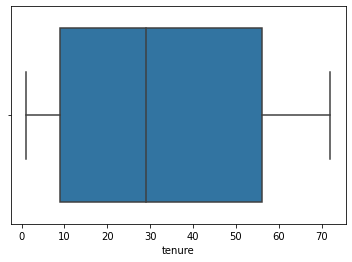

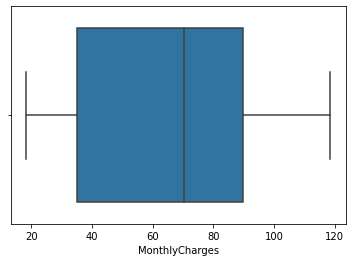

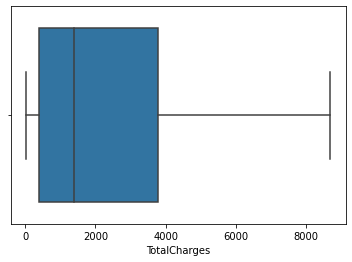

In [15]:
#See observation outliers on the numerical variable on train dataset
# An outlier is any value that lies more than one and a half times the length of the box from either end of the box.
#That is, if a data point is below Q1 – 1.5×IQR or above Q3 + 1.5×IQR, it is viewed as being too far from the central values to be reasonable. 

Q1 = train_df["TotalCharges"].quantile(0.25)
Q3 = train_df["TotalCharges"].quantile(0.75)
IQR = Q3-Q1
lower_range = Q1 -(1.5 * IQR)
upper_range = Q3 +(1.5 * IQR)
for x in df['TotalCharges']:
    if x < lower_range or x > upper_range:
        outliers = x
        print(x)

Q1_m=train_df["MonthlyCharges"].quantile(0.25)
Q3_m=train_df["MonthlyCharges"].quantile(0.75)
IQR_m = Q3_m-Q1_m
lower_range_m = Q1_m -(1.5 * IQR_m)
upper_range_m = Q3_m +(1.5 * IQR_m)
for y in df['MonthlyCharges']:
    if y < lower_range_m or y > upper_range_m:
        outliers = y
        print(y)
        
Q1_t=train_df["tenure"].quantile(0.25)
Q3_t=train_df["tenure"].quantile(0.75)
IQR_t = Q3_t-Q1_t
lower_range_t = Q1_t -(1.5 * IQR_t)
upper_range_t = Q3_t +(1.5 * IQR_t)
for z in df['tenure']:
    if z < lower_range_t or z > upper_range_t:
        outliers = z
        print(z)

for i in numerical:
    sns.boxplot(x=train_df[i])
    plt.show()
#No Outliers were detected as can be also evident from the box plots above 
        

Text(0.5, 1.0, 'Correlation Heatmap')

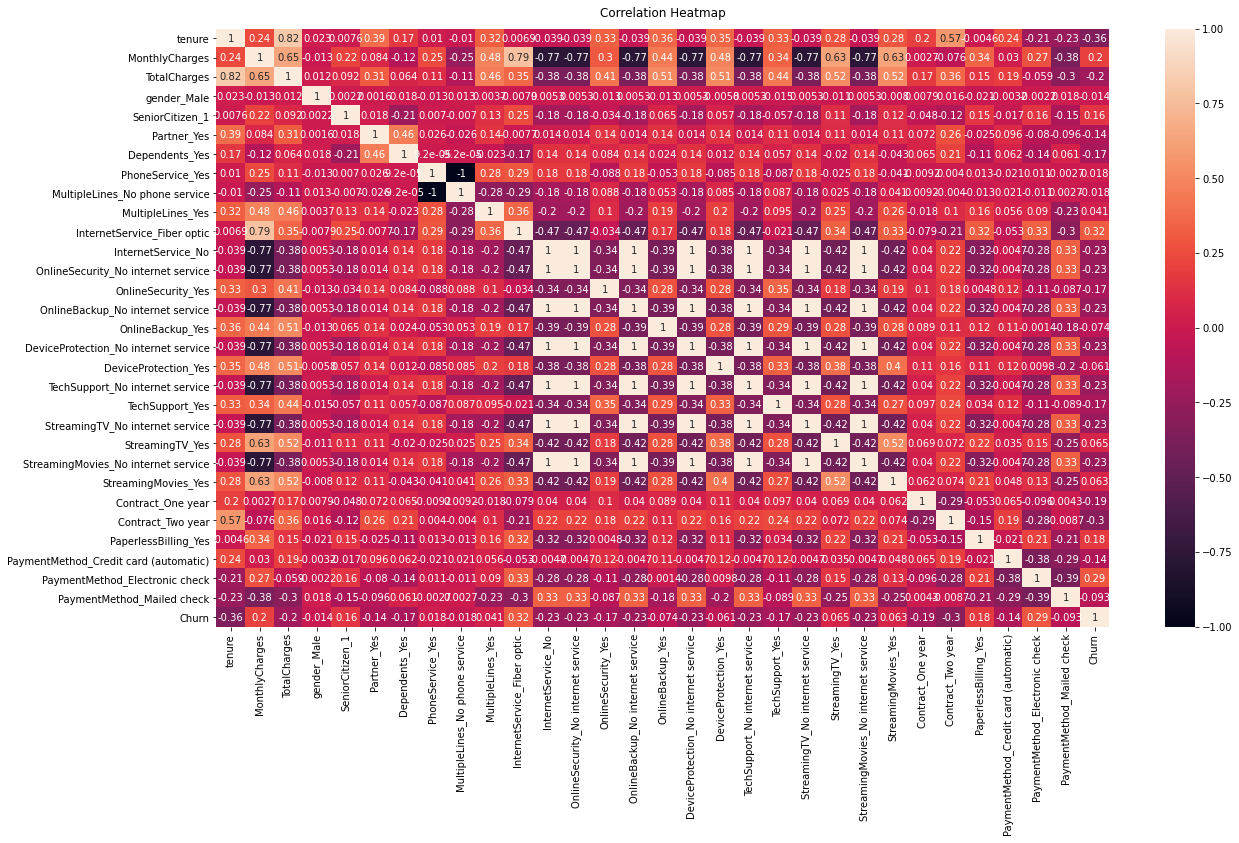

In [17]:
#Checking for correlation (for numerical variables)
corr_matrix = train_df.corr(method= 'pearson')
#To make it easier to find correlation, it is better to visualize the correlation matrix via a heatmap
plt.figure(figsize=(20, 11))
heatmap = sns.heatmap(train_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

As it can be seen from the above correlation post, that the variable Inernet Service_No is correlated to OnlineSecurity_NoInternetService, OnlineBackup_NoInternetService, DeviceProtection_NoInternetService, StreamingTV_NoInternetService, TechSupport_NoInternetService. Hence, only InternetService_No will be kept and rest of the variables will be dropped.  Additionally, MultipleLines_No phone service is negatively correlated to PhoneService_Yes, hence, PhoneService_Yes will be dropped. 

In [18]:
#Dropping the correlated columns from both test and train dataset
train_df = train_df.drop(columns = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service','StreamingTV_No internet service', 'StreamingMovies_No internet service','TechSupport_No internet service','MultipleLines_No phone service' ])
test_df = test_df.drop(columns = ['OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service','StreamingTV_No internet service', 'StreamingMovies_No internet service','TechSupport_No internet service','MultipleLines_No phone service' ])

In [19]:
#Perform Feature Scaling on 'tenure', 'MonthlyCharges', 'TotalCharges' in order to bring them on same scale since the variation between the scale of these variables is of considerable amount 
#We need to standardize the continuous or quantitative variables/ features before applying Machine Learning models. This is important because if we don't standardize the features, features with high variance that are orders of magnitude larger that others might dominate the model fitting process and causing the model unable to learn from other features (with lower variance) correctly as expected.
standardScaler = StandardScaler()
columns_scaling = ['tenure', 'MonthlyCharges', 'TotalCharges']

#Apply the feature scaling operation on both test and train dataset
train_df[columns_scaling] = standardScaler.fit_transform(train_df[columns_scaling])
test_df[columns_scaling] = standardScaler.transform(test_df[columns_scaling])


In [21]:
#Create Feature variable X and Target variable y for both training and test dataset
y = train_df['Churn']
X = train_df.drop(['Churn','customerID'], axis = 1)

y_test = test_df['Churn']
X_test = test_df.drop(['Churn','customerID'], axis = 1)


Feature Engineering using Random Forest to determine the importance of features 

In [22]:
rf = RandomForestClassifier(random_state=42)
#train the model 
model = rf.fit(X, y)
features_rf = model.feature_importances_
#making dataframe of features along with the values of their importance 
feature_rf = pd.DataFrame(list(zip(X.columns,model.feature_importances_)), columns = ['predictor','feature importance'])
#making dataframe of features along with the values of their importance 
feature_rf.sort_values(by = ['feature importance'], ascending = False)

,predictor,feature importance
2,TotalCharges,0.198143
1,MonthlyCharges,0.176818
0,tenure,0.162741
9,InternetService_Fiber optic,0.050798
21,PaymentMethod_Electronic check,0.034103
18,Contract_Two year,0.033669
3,gender_Male,0.028704
19,PaperlessBilling_Yes,0.026333
17,Contract_One year,0.025238
5,Partner_Yes,0.024753


Looking the above results, it can be seen that the insights that were derived by visaluzing the entire dataset were right. For example, InternetService_Fibre Optic and PaymentMethod_Electronic check and contract terms are some of the important variables. This is reasonable considering that these factors were among the ones which varied a lot between churned and non-churned customers when exploratory analysis was performed.

We can consider the features with feature importance below 0.015 to be of no significance. Hence, they can be excluded from the analysis. Two feature lists will be made (one that will have all the variables originally present in the dataset and one with these not significant variables excluded) and models will be trained for both feature list and their performances will be compared. 

However, before training the model, the data would need to balanced because there are only 26% of non-churned customers. Hence SMOTE will be used to sample the data. Different algorithms will be used to train the model and one with the best performance will be tuned. 

In [23]:
X_rf = X.drop(['PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check', 'PhoneService_Yes'], axis = 1)
#need to drop these features from test datset as well 
X_rf_test = X_test.drop(['PaymentMethod_Credit card (automatic)','PaymentMethod_Mailed check', 'PhoneService_Yes'], axis = 1)
#SMOTE analysis on original features 
sm = SMOTE(random_state = 42)
x_train_sm , y_train_sm = sm.fit_sample(X,y)
#SMOTE analysis on significant features (obatined from results using Random Forest)
sm = SMOTE(random_state = 42)
x_rf_sm , y_rf_sm = sm.fit_sample(X_rf,y)

Churn_rate = pd.value_counts(y_train_sm) / len(y_train_sm)
print(Churn_rate)


0    0.5
1    0.5
Name: Churn, dtype: float64


As it can be seen from the results, the distribution of churn vs non-churn is balanced now since the SMOTE added synthetic samples. Now we strat training the model using different algorithms 

# Step 5: Explore many different models and shortlist the best ones

Although F1 score was chosen a paramter that would determine the best perofrming model, other parameters such as recall, precision and area under receving operating chractertstic curve were also determined. The ROC curves were generated as well to visualize the true and false positive rate.

Precision Score 0.5383647798742138
Recall Score 0.7629233511586453
F1 Score 0.631268436578171


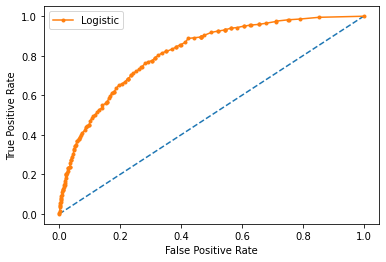

AUC: 0.815


In [24]:
# Run the model
log = LogisticRegression(random_state = 42, max_iter = 10000)
model1 = log.fit(x_train_sm,y_train_sm)
y_test_pred_log = model1.predict(X_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_log))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_log))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_log))

probs = model.predict_proba(X_test)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc_score)

Precision Score 0.5184304399524375
Recall Score 0.7771836007130125
F1 Score 0.6219686162624821


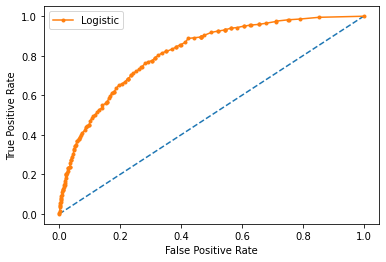

AUC: 0.825


In [29]:
# Run the model
log1 = LogisticRegression(random_state = 42, max_iter = 10000)
model2 = log1.fit(x_rf_sm , y_rf_sm)
y_test_pred_log1 = model2.predict(X_rf_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_log1))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_log1))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_log1))

probs1 = model2.predict_proba(X_rf_test)
probs1 = probs1[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, probs1)
print('AUC: %.3f' % auc_score)

Precision Score 0.5506329113924051
Recall Score 0.6203208556149733
F1 Score 0.5834031852472757


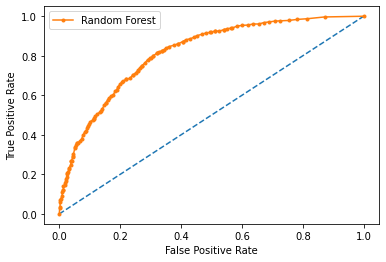

AUC: 0.816


In [30]:
rf = RandomForestClassifier(random_state = 42)
model3 = rf.fit(x_train_sm,y_train_sm)
y_test_pred_rf = model3.predict(X_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_rf))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_rf))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_rf))

rf_probs = model3.predict_proba(X_test)
rf_probs = rf_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, rf_probs)
print('AUC: %.3f' % auc_score)


Precision Score 0.5529225908372828
Recall Score 0.6238859180035651
F1 Score 0.5862646566164154


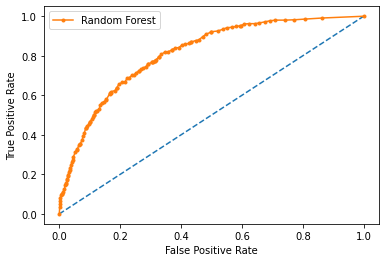

AUC: 0.813


In [31]:
rf1 = RandomForestClassifier(random_state = 42)
model4 = rf1.fit(x_rf_sm , y_rf_sm)
y_test_pred_rf1 = model4.predict(X_rf_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_rf1))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_rf1))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_rf1))

rf_probs1 = model4.predict_proba(X_rf_test)
rf_probs1 = rf_probs1[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, rf_probs1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, rf_probs1)
print('AUC: %.3f' % auc_score)


Precision Score 0.5188335358444714
Recall Score 0.7611408199643493
F1 Score 0.6170520231213873


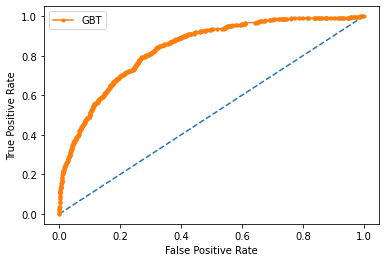

AUC: 0.837


In [32]:
gbt = GradientBoostingClassifier(random_state=42)
model5 = gbt.fit(x_train_sm,y_train_sm)
y_test_pred_gbt = model5.predict(X_test)
#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_gbt))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_gbt))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_gbt))

gbt_probs = model5.predict_proba(X_test)
gbt_probs = gbt_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbt_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='GBT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, gbt_probs)
print('AUC: %.3f' % auc_score)


Precision Score 0.5147058823529411
Recall Score 0.7486631016042781
F1 Score 0.6100217864923748


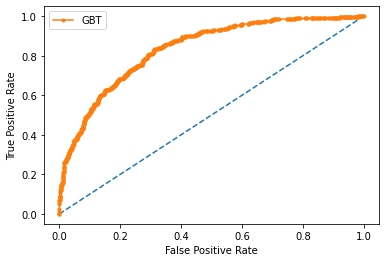

AUC: 0.834


In [33]:
gbt1 = GradientBoostingClassifier(random_state=42)
model6 = gbt1.fit(x_rf_sm , y_rf_sm)
y_test_pred_gbt1 = model6.predict(X_rf_test)
#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_gbt1))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_gbt1))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_gbt1))

gbt_probs1 = model6.predict_proba(X_rf_test)
gbt_probs1 = gbt_probs1[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, gbt_probs1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='GBT')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, gbt_probs1)
print('AUC: %.3f' % auc_score)


Precision Score 0.47038724373576307
Recall Score 0.7361853832442068
F1 Score 0.5740097289784573


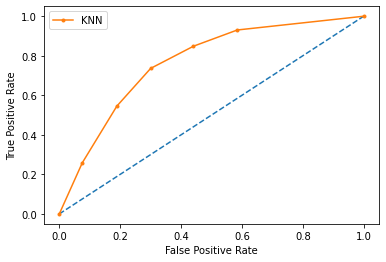

AUC: 0.767


In [34]:
knn = KNeighborsClassifier()
model7 = knn.fit(x_train_sm,y_train_sm)
y_test_pred_knn = model7.predict(X_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_knn))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_knn))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_knn))

knn_probs = model7.predict_proba(X_test)
knn_probs = knn_probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, knn_probs)
print('AUC: %.3f' % auc_score)


Precision Score 0.4865497076023392
Recall Score 0.7415329768270945
F1 Score 0.5875706214689265


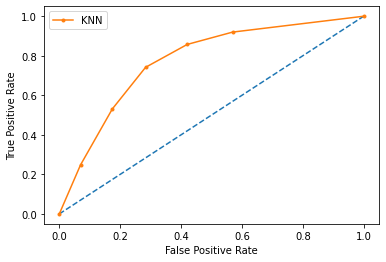

AUC: 0.774


In [35]:
knn1 = KNeighborsClassifier()
model8 = knn1.fit(x_rf_sm , y_rf_sm)
y_test_pred_knn1 = model8.predict(X_rf_test)

#Calculate precision
print("Precision Score", precision_score(y_test,y_test_pred_knn1))

#Calculate recall
print("Recall Score", recall_score(y_test,y_test_pred_knn1))

#Calculate f1 score
print("F1 Score", f1_score(y_test,y_test_pred_knn1))

knn_probs1 = model8.predict_proba(X_rf_test)
knn_probs1 = knn_probs1[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, knn_probs1)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.show()
auc_score = roc_auc_score(y_test, knn_probs1)
print('AUC: %.3f' % auc_score)


As it can be seen from above results, almost all of the models performed better with the original feature list as compared to the list which excluded features with less importance. Logistic Regression and GBT (with all features included) had the highest F1 score when compared with KNN and Random Forest. 

Now these model will be cross validated to evaluate how well machine learning models performs on a new dataset.One point to consider here is that the SMOTE should be done within cross validation to prevent any data leakage. The k-fold method of cross validation was applied. Since KNN has the worst F1 score, it wasn't evaluated using cross validation.


In [41]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state = 42, shuffle = True)
for train_index, test_index in kf.split(X,y):
    X_train = X.iloc[train_index]
    y_train =y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    sm = SMOTE(random_state = 42)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    logistic = LogisticRegression(random_state = 42, max_iter = 10000)
    model9 =  logistic.fit( X_train_oversampled, y_train_oversampled)
    y_pred = model9.predict(X_test)
    print(f'f-score: {f1_score(y_test, y_pred)}')

f-score: 0.6224328593996841
f-score: 0.6500777604976672
f-score: 0.6149162861491628
f-score: 0.6128500823723229
f-score: 0.5909849749582637


In [42]:
kf = KFold(n_splits=5, random_state = 42, shuffle = True)
for train_index, test_index in kf.split(X,y):
    X_train = X.iloc[train_index]
    y_train =y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    sm = SMOTE(random_state = 42)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    gbt_kf = GradientBoostingClassifier(random_state=42)
    model10 = gbt_kf.fit( X_train_oversampled, y_train_oversampled)
    y_pred = model10.predict(X_test)
    print(f'f-score: {f1_score(y_test, y_pred)}')

f-score: 0.6296900489396411
f-score: 0.6602870813397128
f-score: 0.632398753894081
f-score: 0.6405228758169935
f-score: 0.604810996563574


In [43]:
kf = KFold(n_splits=5, random_state = 42, shuffle = True)
for train_index, test_index in kf.split(X,y):
    X_train = X.iloc[train_index]
    y_train =y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    sm = SMOTE(random_state = 42)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train)
    rf_kf = RandomForestClassifier(random_state = 42)
    model11 = rf_kf.fit( X_train_oversampled, y_train_oversampled)
    y_pred = model11.predict(X_test)
    print(f'f-score: {f1_score(y_test, y_pred)}')

f-score: 0.6104129263913824
f-score: 0.6572934973637962
f-score: 0.5968586387434556
f-score: 0.5888888888888889
f-score: 0.5676190476190476


On an average, GBT and Logistic Regression performed very well with GBT having an avaregae F1 score of 0.63 and Logistic Regression having around 0.62. Since GBT had the highest F1 score, it would be fine tuned to see if its performance can be improved. 

# Step 6: Fine-tune the models

Since GridSearch CV is usually computationally expensive, it was decided not to use it to fine tune the model. RandomizedSearchCV was used instead. 

In [299]:
grid_param = {'learning_rate': [0.05, 0.1]
                                    ,'n_estimators':[100,150,200]
                                    ,'max_depth':[3,5,7]
                                    ,'min_samples_split':[0.1, 0.5, 1.0]
                                    ,'min_samples_leaf':[2, 5, 10]
                                    ,'subsample': [0.1, 0.5, 0.7]
                                    }

gbt_tune = GradientBoostingClassifier(random_state=42)
gbr = RandomizedSearchCV(estimator = gbt_tune, cv=5, param_distributions= grid_param, scoring = 'f1')
model12 = gbr.fit(x_train_sm,y_train_sm)
y_test_pred_gbt = model12.predict(X_test)
best_params_gbt = model12.best_params_
print(model12.best_params_)

{'subsample': 0.5, 'n_estimators': 200, 'min_samples_split': 0.1, 'min_samples_leaf': 10, 'max_depth': 5, 'learning_rate': 0.05}


# Final Classification Model 

In [45]:
gbt3= GradientBoostingClassifier(random_state=42, subsample = 0.5, n_estimators= 200, min_samples_split =0.1, min_samples_leaf = 10, max_depth= 5, learning_rate = 0.05)
model13 = gbt3.fit(x_train_sm , y_train_sm)
y_test_pred_gbt2 = model13.predict(X_test)
print("F1 Score", f1_score(y_test,y_test_pred_gbt2))


F1 Score 0.629757785467128


The model above is tuned and gave better F1 score as compared to the model above. This model will be used to classify the customers as churn vs non-churn. 